실습 과제

## 라이브러리

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, utils, callbacks
import matplotlib.pyplot as plt

## 데이터

In [ ]:
! gdown "https://drive.google.com/u/0/uc?id=1t2qIgpWdWX_n5OC8P2ZiDfPIQ98NY_PB&export=download"

Downloading...
From: https://drive.google.com/u/0/uc?id=1t2qIgpWdWX_n5OC8P2ZiDfPIQ98NY_PB&export=download
To: /content/celeba_small.npz
100% 174M/174M [00:00<00:00, 192MB/s]


In [ ]:
celeba = np.load("celeba_small.npz")
list(celeba.keys())

['train_images', 'train_labels', 'test_images', 'test_labels']

In [ ]:
x_train = celeba["train_images"]
y_train = celeba["train_labels"]
x_test = celeba["test_images"]
y_test = celeba["test_labels"]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2000, 72, 59, 3), (2000, 2), (200, 72, 59, 3), (200, 2))

In [ ]:
y1_train = y_train[:,0]
y2_train = y_train[:,1]
y1_test = y_test[:,0]
y2_test = y_test[:,1]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

In [ ]:
x_train.shape, x_test.shape, y1_train.shape, y2_train.shape, y1_test.shape, y2_test.shape

((2000, 72, 59, 3), (200, 72, 59, 3), (2000,), (2000,), (200,), (200,))

(array([3085., 2167., 1692., 1645., 1229., 1173.,  853.,  576.,  269.,
          55.]),
 array([3.32336324e-05, 9.54955965e-02, 1.90957959e-01, 2.86420322e-01,
        3.81882685e-01, 4.77345048e-01, 5.72807411e-01, 6.68269774e-01,
        7.63732137e-01, 8.59194500e-01, 9.54656863e-01]),
 <a list of 10 Patch objects>)

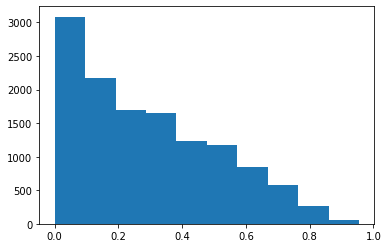

In [ ]:
plt.hist(x_train[0].flatten())

In [ ]:
def build_model():
    x = layers.Input(shape=(72,59,3), name="Input")

    y = layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", name="C1")(x)
    y = layers.BatchNormalization(name="N1")(y)
    y = layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same", name="C2")(y)
    y = layers.BatchNormalization(name="N2")(y)
    y = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), name="P1")(y)
    y = layers.Flatten(name="Flatten")(y)
    
    # gender
    y1 = layers.Dense(1024, activation="relu")(y)
    y1 = layers.Dropout(0.5)(y1)
    y1 = layers.Dense(128, activation="relu")(y1)
    y1 = layers.Dropout(0.5)(y1)
    y1 = layers.Dense(1, activation="sigmoid", name="gender_output")(y1)
    
    # issmile
    y2 = layers.Dense(1024, activation="relu")(y)
    y2 = layers.Dropout(0.5)(y2)
    y2 = layers.Dense(128, activation="relu")(y2)
    y2 = layers.Dropout(0.5)(y2)
    y2 = layers.Dense(1, activation="sigmoid", name="issmile_output")(y2)
    
    return models.Model(x,[y1, y2])

model = build_model()
model.summary()
# utils.plot_model(model, show_shapes=True

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 72, 59, 3)]  0           []                               
                                                                                                  
 C1 (Conv2D)                    (None, 72, 59, 64)   4864        ['Input[0][0]']                  
                                                                                                  
 N1 (BatchNormalization)        (None, 72, 59, 64)   256         ['C1[0][0]']                     
                                                                                                  
 C2 (Conv2D)                    (None, 72, 59, 64)   102464      ['N1[0][0]']                     
                                                                                            

In [ ]:
model.compile(loss=["binary_crossentropy", "binary_crossentropy"],
              optimizer="adam",
              metrics=["acc"])

In [ ]:
history = model.fit(x_train, [y1_train, y2_train], validation_split=0.2, epochs=5)

Epoch 1/5
50/50 [==============================] - 16s 71ms/step - loss: 31.9542 - gender_output_loss: 16.3692 - issmile_output_loss: 15.5850 - gender_output_acc: 0.5738 - issmile_output_acc: 0.5412 - val_loss: 4.3112 - val_gender_output_loss: 1.9449 - val_issmile_output_loss: 2.3663 - val_gender_output_acc: 0.4850 - val_issmile_output_acc: 0.5350
Epoch 2/5
50/50 [==============================] - 3s 54ms/step - loss: 3.4232 - gender_output_loss: 1.8467 - issmile_output_loss: 1.5766 - gender_output_acc: 0.6194 - issmile_output_acc: 0.5569 - val_loss: 32.0072 - val_gender_output_loss: 11.6767 - val_issmile_output_loss: 20.3304 - val_gender_output_acc: 0.4700 - val_issmile_output_acc: 0.4750
Epoch 3/5
50/50 [==============================] - 3s 52ms/step - loss: 1.6389 - gender_output_loss: 0.8048 - issmile_output_loss: 0.8341 - gender_output_acc: 0.5981 - issmile_output_acc: 0.5063 - val_loss: 30.3957 - val_gender_output_loss: 9.7991 - val_issmile_output_loss: 20.5966 - val_gender_outpu

In [ ]:
model = build_model()
model.compile(loss=["binary_crossentropy", "binary_crossentropy"],
              optimizer="adam",
              metrics=["acc"])

ckp = callbacks.ModelCheckpoint("model.h5",
                                save_best_only=True,
                                monitor="val_loss")
early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         patience=10)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                        patience=5,
                                        facotr=0.1 # 학습률을 1/10 으로 줄임
                                        )
tb = callbacks.TensorBoard(log_dir="my_log_dir")

history = model.fit(x_train, [y1_train, y2_train],
                    validation_split=0.2,
                    epochs=50,
                    callbacks=[ckp, early_stopping, reduce_lr, tb])

Epoch 1/50
50/50 [==============================] - 10s 186ms/step - loss: 34.9181 - gender_output_loss: 15.6751 - issmile_output_loss: 19.2430 - gender_output_acc: 0.5694 - issmile_output_acc: 0.5138 - val_loss: 7.9429 - val_gender_output_loss: 1.5664 - val_issmile_output_loss: 6.3765 - val_gender_output_acc: 0.5950 - val_issmile_output_acc: 0.4750 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 3s 55ms/step - loss: 4.8925 - gender_output_loss: 2.2711 - issmile_output_loss: 2.6214 - gender_output_acc: 0.5663 - issmile_output_acc: 0.5419 - val_loss: 14.8671 - val_gender_output_loss: 9.3101 - val_issmile_output_loss: 5.5570 - val_gender_output_acc: 0.5300 - val_issmile_output_acc: 0.4750 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 9s 180ms/step - loss: 1.7845 - gender_output_loss: 0.9037 - issmile_output_loss: 0.8807 - gender_output_acc: 0.5569 - issmile_output_acc: 0.5219 - val_loss: 7.5363 - val_gender_output_loss: 5.9922 - val_issmile_output_loss

In [ ]:
model.evaluate(x_test, [y1_test, y2_test])

7/7 [==============================] - 0s 50ms/step - loss: 0.6537 - gender_output_loss: 0.3910 - issmile_output_loss: 0.2626 - gender_output_acc: 0.9250 - issmile_output_acc: 0.9050


[0.6536628603935242,
 0.39104190468788147,
 0.26262083649635315,
 0.925000011920929,
 0.9049999713897705]

## Batch normalize를 사용하는 이유

1. 배치 정규화는 단순하게 평균과 분산을 구하는 것이 아니라 감마(Scale), 베타(Shift) 를 통한 변환을 통해 비선형 성질을 유지 하면서 학습 될 수 있게 해줌 
1. 배치 정규화가 신경망 레이어의 중간 중간에 위치하게 되어 학습을 통해 감마, 베타를 구할 수 있음 
1. Internal Covariate Shift 문제로 인해 신경망이 깊어질 경우 학습이 어려웠던 문제점을 해결
1. gradient 의 스케일이나 초기 값에 대한 dependency 가 줄어들어 Large Learning Rate 를 설정할 수 있기 떄문에 결과적으로 빠른 학습 가능함, 즉, 기존 방법에서 learning rate 를 높게 잡을 경우 gradient 가 vanish/explode 하거나 local minima 에 빠지는 경향이 있었는데 이는 scale 때문이었으며, 배치 정규화를 사용할 경우 propagation 시 파라미터의 scale 에 영향을 받지 않게 되기 때문에 learning rate 를 높게 설정할 수 있는 것임
1. regularization 효과가 있기 때문에 dropout 등의 기법을 사용하지 않아도 됨 (효과가 같기 때문)
1. 학습 시 Deterministic 하지 않은 결과 생성 
1. Learning Rate Decay 를 더 느리게 설정 가능
1. 입력의 범위가 고정되기 때문에 saturating 한 함수를 활성화 함수로 써도 saturation 문제가 일어나지 않음, 여기서 saturation 문제란 가중치의 업데이트가 없어지는 현상임

* [출처 : https://eehoeskrap.tistory.com/430 ]